### Compare with PyHEADTAIL

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import xwakes as xw
import xtrack as xt
import xfields as xf
import xpart as xp

from scipy.interpolate import interp1d
from scipy.integrate import quad

import pandas as pd

#### Machine parameters

In [2]:
p0c = 2.794987e9
circumference = 2*np.pi*100

h_RF = 7 
V_RF = 50e3 
dphi_RF = 0 
f_rev = 452640.7547465239
f_RF = f_rev*h_RF
alpha_c = 0.02687

bucket_length = circumference / h_RF

Q_x = 6.225
Q_y = 6.24

In [3]:
n_macroparticles_per_slice = 1500

epsn_x = 3.25e-6 
epsn_y = 3.25e-6
sigma_z = 12.36
z_cut = 3 * sigma_z

#### Initialize PS

In [4]:
one_turn_map = xt.LineSegmentMap(
    length=circumference, betx=16., bety=16.,
    qx=Q_x, qy=Q_y,
    voltage_rf=V_RF, frequency_rf=f_RF,
    lag_rf=dphi_RF, momentum_compaction_factor=alpha_c
)

line = xt.Line(elements=[one_turn_map], element_names=['one_turn_map'])
line.particle_ref = xt.Particles(p0c=p0c)
line.build_tracker()

#### Method to calculate the momentum kick from wakefield

In [5]:
def slice_mean_px(bunch, wf):
    mean_px = []
    for z_center in wf.slicer._zeta_slice_centers:
        z0 = z_center - wf.slicer.dzeta/2
        z1 = z_center + wf.slicer.dzeta/2

        indices = np.where((bunch.zeta > z0) & (bunch.zeta < z1))[0]
        if np.size(indices) == 0:
            mean_px.append(0)
        else:
            mean_px.append(np.mean(bunch.px[indices]))

    mean_px = np.array(mean_px)

    return mean_px

In [6]:
def compute_wake_potential_with_convolution(wf, n_macroparticles_per_slice, n_slices_wake, epsn_x, epsn_y, sigma_z, z_cut):
    n_macroparticles = n_macroparticles_per_slice * n_slices_wake

    wf.configure_for_tracking( zeta_range=(-z_cut, z_cut), num_slices=n_slices_wake,
                               bunch_spacing_zeta=bucket_length, circumference=circumference)

    bunch = xp.generate_matched_gaussian_bunch(line=line,
                    num_particles=n_macroparticles, total_intensity_particles=1e11,
                    nemitt_x=epsn_x, nemitt_y=epsn_y, sigma_z=sigma_z)

    bunch.x += 1e-3
    bunch.y += 1e-3

    xp_before_kick = slice_mean_px(bunch, wf) 
    wf.track(bunch)
    xp_after_kick = slice_mean_px(bunch, wf) 

    kick_xp = xp_after_kick - xp_before_kick

    window = np.size(wf.slicer._zeta_slice_centers)//10
    z_convolution = wf.slicer._zeta_slice_centers[window//2:-window//2+1]
    wake_potential_convolution = np.convolve(kick_xp, np.ones(window), "valid")/window
    
    return z_convolution, wake_potential_convolution

In [7]:
wakefile = ('PS_wall_impedance_Ekin_2.0GeV.wake')
wakefile_columns = ['time', 'dipolar_x', 'dipolar_y', 'quadrupolar_x', 'quadrupolar_y']
wake_df = xw.read_headtail_file(wakefile, wakefile_columns)

#### Wake Table

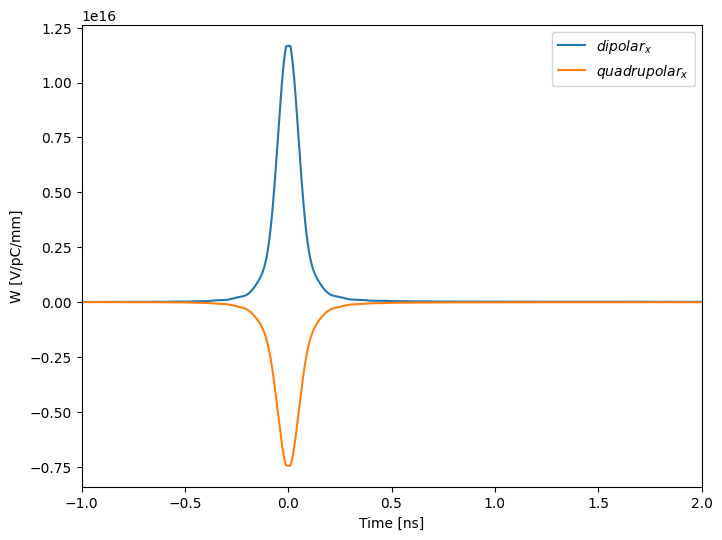

In [8]:
plt.figure(figsize=(8,6))
plt.plot(wake_df['time']*1e9, wake_df['dipolar_x'], label=r'$dipolar_x$')
plt.plot(wake_df['time']*1e9, wake_df['quadrupolar_x'], label=r'$quadrupolar_x$')
plt.xlabel('Time [ns]')
plt.ylabel('W [V/pC/mm]')
plt.legend()
plt.xlim(-1, 2)
plt.show()

#### Interpolated Method

In [9]:
wf_interpolated = xw.WakeFromTable(table=wake_df, columns=wakefile_columns, method="Interpolated")

In [10]:
n_slices_interpolated = 1000
wake_pot_xwakes = compute_wake_potential_with_convolution(wf_interpolated, n_macroparticles_per_slice, n_slices_interpolated, 
                                                        epsn_x, epsn_y, sigma_z, z_cut)

*** Maximum RMS bunch length 14.136748082986825m.
... distance to target bunch length: -1.2360e+01
... distance to target bunch length: 1.3869e+00
... distance to target bunch length: 1.2908e+00
... distance to target bunch length: -3.5264e-01
... distance to target bunch length: 3.7869e-01
... distance to target bunch length: 5.6220e-02
... distance to target bunch length: 7.1585e-03
... distance to target bunch length: -2.4692e-05
... distance to target bunch length: 7.3048e-08
--> Bunch length: 12.360000073047518
--> Emittance: 2.5174077287058387
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [11]:
wake_pot_pyheadtail = np.load('pyheadtail_results/interpolated.npy')

#### Integrated Method

In [12]:
wf_integrated = xw.WakeFromTable(table=wake_df, columns=wakefile_columns, method="Integrated")

In [13]:
n_slices_integrated = 1000
wake_pot_ig_xwakes = compute_wake_potential_with_convolution(wf_integrated, n_macroparticles_per_slice, n_slices_integrated, 
                                                        epsn_x, epsn_y, sigma_z, z_cut)

*** Maximum RMS bunch length 14.136748082986825m.
... distance to target bunch length: -1.2360e+01
... distance to target bunch length: 1.3869e+00
... distance to target bunch length: 1.2908e+00
... distance to target bunch length: -3.5264e-01
... distance to target bunch length: 3.7869e-01
... distance to target bunch length: 5.6220e-02
... distance to target bunch length: 7.1585e-03
... distance to target bunch length: -2.4692e-05
... distance to target bunch length: 7.3048e-08
--> Bunch length: 12.360000073047518
--> Emittance: 2.5174077287058387


/Users/miltiadis_bozatzis/Documents/xwakes/xwakes/wit/component.py:1471: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrated_bins.append(quad(self.wake, t[0][i], t[0][i] + dt,


In [14]:
wake_pot_ig_pyheadtail = np.load('pyheadtail_results/integrated.npy', allow_pickle=True)

#### Results

Text(0, 0.5, 'Kick [a.u.]')

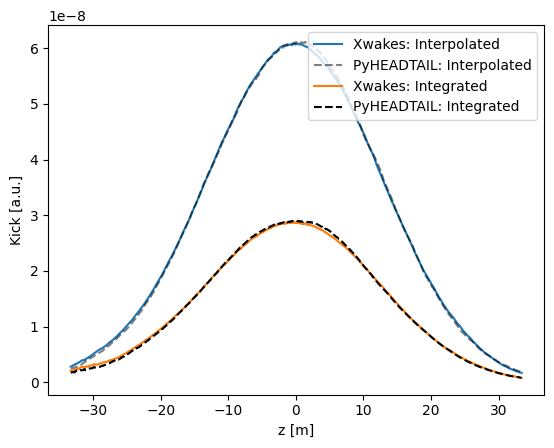

In [15]:
plt.plot(wake_pot_xwakes[0], wake_pot_xwakes[1], label = 'Xwakes: Interpolated')
plt.plot(wake_pot_pyheadtail[0], wake_pot_pyheadtail[1], 'k--', alpha = 0.5, label = 'PyHEADTAIL: Interpolated')

plt.plot(wake_pot_ig_xwakes[0], wake_pot_ig_xwakes[1], label = 'Xwakes: Integrated')
plt.plot(wake_pot_ig_pyheadtail[0], wake_pot_ig_pyheadtail[1], 'k--', label = 'PyHEADTAIL: Integrated')

plt.legend(loc = 'upper right')
plt.xlabel('z [m]')
plt.ylabel('Kick [a.u.]')